# Feature to response correlation analysis on TF affinity scores obtained from a window of size 2kb around TSS
We decided to change the window size centered on the TSS of the genes estimating the binding affinities of the TFs binding in that region.

## Load the partitioned and normalized data (to save I/O operations)

In [16]:
## The code illustrating how the RData loaded in the cell below is generated (too heavy for jupyter to run).

## Read the static features and assign the ENSG column as rownames
# x <- read.table("/MMCI/MS/EpiregDeep2/work/Tools/TEPIC_GS/hg38_Static/2kb/Static_hg38_PromFeatures_2kb_Gene_View.txt", header= T, stringsAsFactors= F)
# rownames(x) <- x$gene_id
# x <- x[, -1]
#########################################################
## Read bulk rna data
# bulk.rna <- read.table("/MMCI/MS/DEEP-liver/work/Data/41/mRNA/LiHe/GRCh37/41_Hf01_LiHe_Ct_mRNA_K_1.LXPv1.20150530_genes.fpkm_tracking",header= T, stringsAsFactors =  F)
# new_gene_id <- sapply(seq(nrow(bulk.rna)), function(i)strsplit(bulk.rna$gene_id[i ], "\\.")[[1]][1])                                                                                                                                       
# bulk.rna$gene_id <- new_gene_id                                                                                                                                                                                                            
# bulk.rna.original <- bulk.rna                                                                                                                                                                                                              
# dupl.genes <- duplicated(bulk.rna$gene_id)                                                                                                                                                                                                 
# bulk.rna <- bulk.rna[!dupl.genes, ]                                                                                                                                                                                                        
# gene_names <- bulk.rna$gene_id                                                                                                                                                                                                             
# bulk.rna <- data.frame(FPKM= bulk.rna$FPKM)                                                                                                                                                                                                
# rownames(bulk.rna) <- gene_names               
#########################################################
## Find the genes in x (static features) that exist in bulk.rna
# x.hits <- which(rownames(x) %in% rownames(bulk.rna))
############
## subset x according to the hits with bulk.rna genes
# x <- x[x.hits, ]
#########################################################
## Find the bulk.rna genes corresponding to the static feature genes (for each gene in x look for the hit index in bulk.rna)
# idx <- NULL;
# for(i in seq(nrow(x)))
#    idx <- c(idx, which(rownames(x)[i] == rownames(bulk.rna)))
#############
## subset y according to the hits with x genes
# y <- bulk.rna[idx, ]
############
## Check if the subset variables match
# all.equal(rownames(x), rownames(bulk.rna)[idx])
##[1] TRUE
############
## Save the variables, ready to be loaded in jupyter
# save(x, y, file= "TF_hg38_2kb_LiHe.RData")

In [17]:
load("../TF_hg38_2kb_LiHe.RData")

### List of variables in the workspace after loading the data file

In [18]:
print(ls())

[1] "log.cors"   "raw.cors"   "x"          "x_filtered" "y"         
[6] "y_filtered" "zeros.idx" 


### Dimensions of the training and test data

In [3]:
print("x:")
print(dim(x))

print("y:")
print(length(y))

[1] "x:"
[1] 52527   726
[1] "y:"
[1] 52527


In [4]:
print(range(x))
print(range(y))

[1] 0.000000 1.209771
[1]     0.0 12081.8


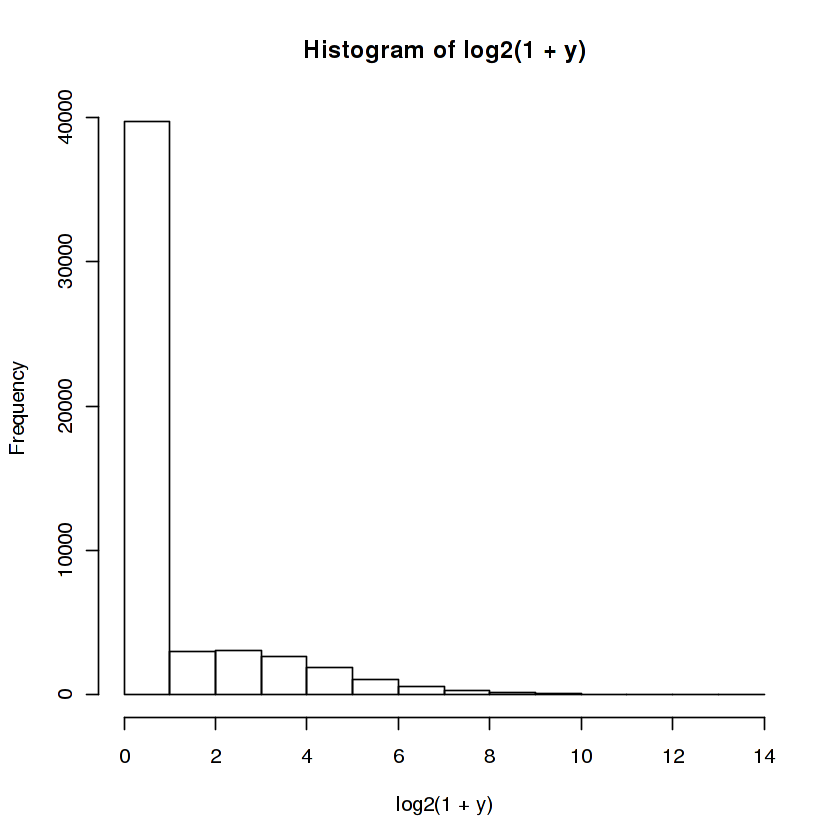

In [6]:
hist(log2(1 + y))

## Compute feature to response correlations (unfiltered data)

### Raw data (original space)

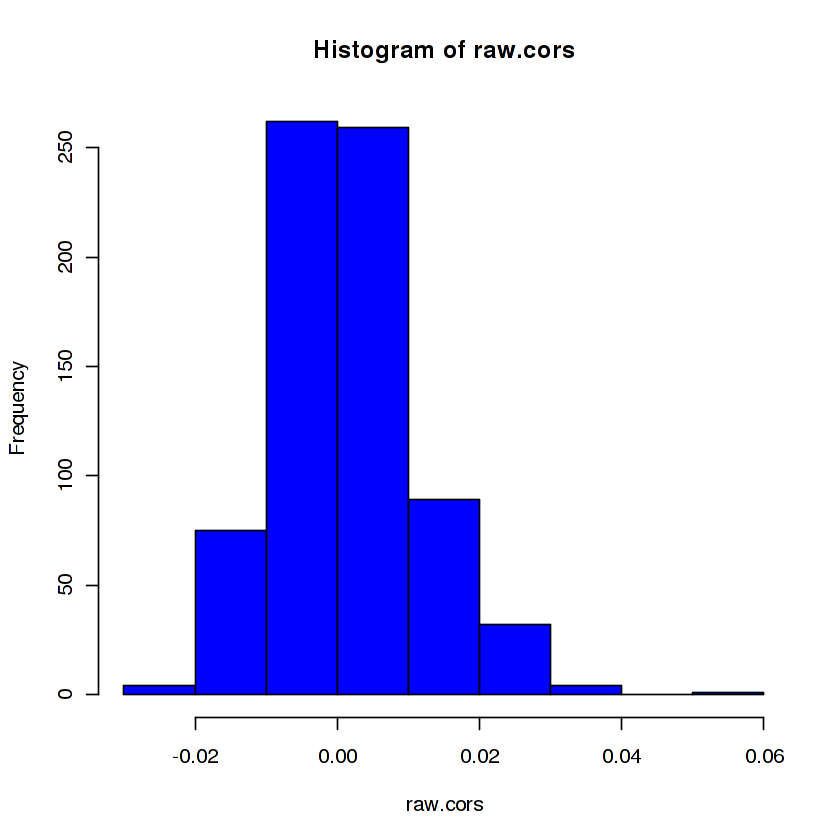

In [7]:
raw.cors <- sapply(seq(ncol(x)), function(i)cor(y, x[, i]))
hist(raw.cors, col= "blue")

### Log-transformed data (log space)

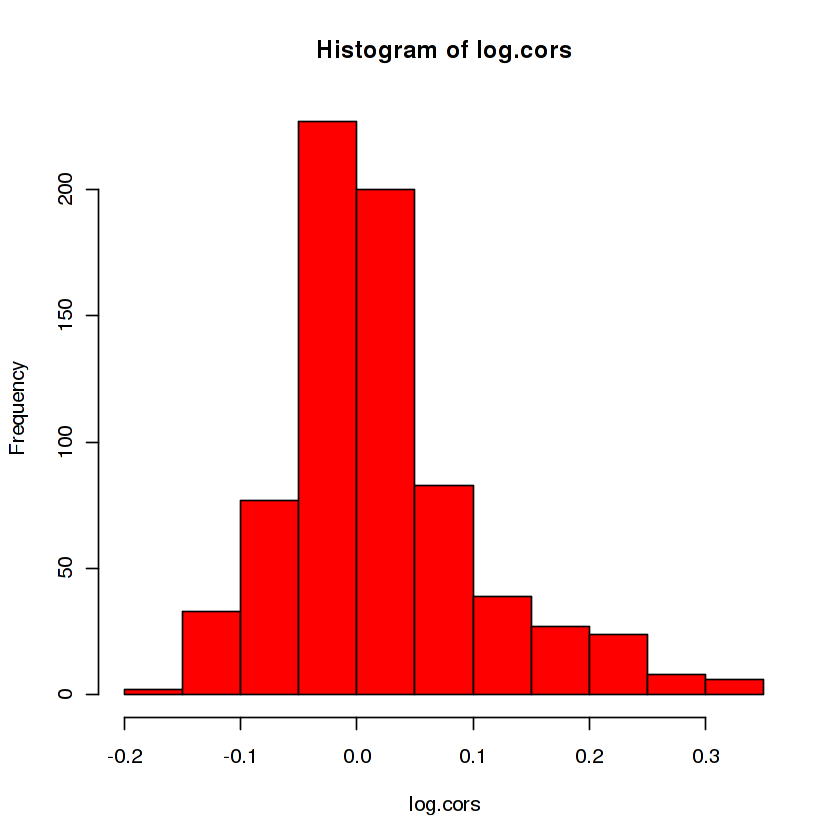

In [8]:
log.cors <- sapply(seq(ncol(x)), function(i)cor(log2(1 + y), log2(1 + x[, i])))
hist(log.cors, col= "red")

## Remove zero-expressed genes

In [9]:
zeros.idx <- which(y == 0)
print(length(zeros.idx))

[1] 29948


In [10]:
x_filtered <- x[-zeros.idx, ]
y_filtered <- y[-zeros.idx]

In [11]:
print(dim(x_filtered))
print(length(y_filtered))

[1] 22579   726
[1] 22579


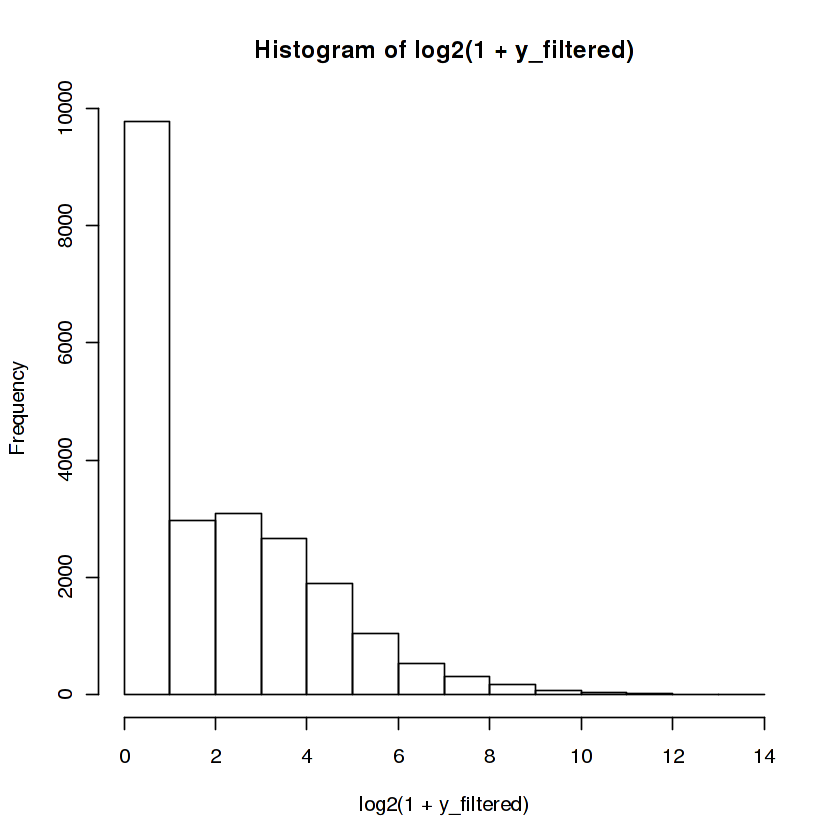

In [12]:
hist(log2(1 + y_filtered))

## Compute feature to response correlations (filtered data)

### Raw filtered data (original space)

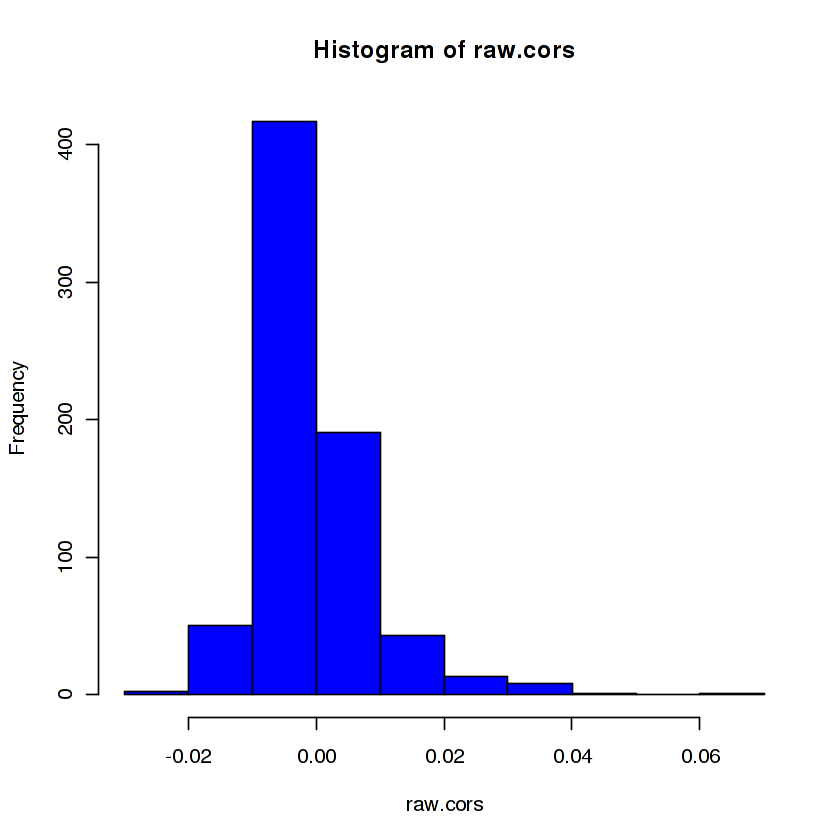

In [13]:
raw.cors <- sapply(seq(ncol(x_filtered)), function(i)cor(y_filtered, x_filtered[, i]))

hist(raw.cors, col= "blue")

### Log-transformed filtered data (log space)

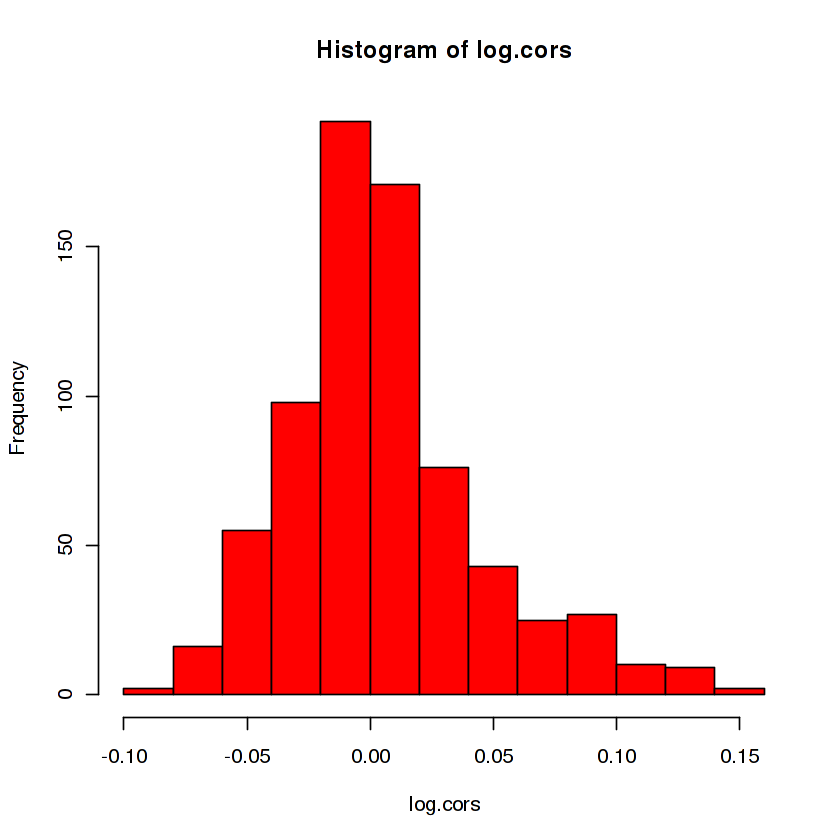

In [14]:
log.cors <- sapply(seq(ncol(x_filtered)), function(i)cor(log2(1 + y_filtered), log2(1 + x_filtered[, i])))

hist(log.cors, col= "red")

# Conclusion
* We examined the influence of the window size ([100bp](https://github.com/fba67/scMTL/blob/master/feat2resp_bulk_LiHe_100bpWinTF.ipynb), [200bp](https://github.com/fba67/scMTL/blob/master/feat2resp_bulk_LiHe_200bpWinTF.ipynb), and [500bp](https://github.com/fba67/scMTL/blob/master/feat2resp_bulk_LiHe_500bpWinTF.ipynb)) used to annotate the TF binding affinities around the TSS on the feature values and how that affects the strength of association between features and response
* Also, measured the correlation between each TF and gene expression for both 1) raw and 2) log-transformed data.
* We filtered the zero-expressed genes (discarded ~30,000 genes with exact zero expression) and this leads to a smaller correlation range compared to the unfiltered data
* When the filtered data is considered, it seems like that the largest window size gives better correlation values (but it seems kind of on par with 500bp)

# Train Elastic Net models on the full data (unfiltered)

## Partition data into training and test sets
80% for training and 20% for test

In [19]:
train_cnt <- floor(nrow(x) * .8)
print(train_cnt)

[1] 42021


In [20]:
set.seed(1)
shuffle.idx <- sample(nrow(x))

In [21]:
train_x <- x[shuffle.idx[seq(train_cnt)], ]
train_y <- y[shuffle.idx[seq(train_cnt)]]

test_x <- x[-shuffle.idx[seq(train_cnt)], ]
test_y <- y[-shuffle.idx[seq(train_cnt)]]

print(dim(train_x))
print(dim(test_x))

[1] 42021   726
[1] 10506   726


In [22]:
train_x <- log2(1 + train_x)
train_y <- log2(1 + train_y)

test_x <- log2(1 + test_x)
test_y <- log2(1 + test_y)

In [23]:
mean.train <- apply(x, 2, FUN= mean)
sd.train <- apply(x, 2, FUN= sd)
train_x <- scale(train_x)

test_x <- scale(test_x, center = mean.train, scale = sd.train)

In [24]:
train_y <- scale(train_y)

col_means_train <- attr(train_y, "scaled:center") 
col_stddevs_train <- attr(train_y, "scaled:scale")
test_y <- scale(test_y, center = col_means_train, scale = col_stddevs_train)

In [25]:
library(glmnet)
library(doMC)
registerDoMC(cores=4)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: iterators
Loading required package: parallel


## CV round on the denoted alpha search grid

In [26]:
alphas <- seq(0, 1, .05)
el.res <- list()
for(i in seq(length(alphas)))
    el.res[[i]] <- cv.glmnet(x= as.matrix(train_x), y= as.numeric(train_y), alpha= alphas[i], nfolds= 5, parallel= T, standardize =F)

## Fetch the best alpha value

In [27]:
all.cvms <- sapply(seq(length(el.res)), function(i) min(el.res[[i]]$cvm))
best.el.cv <- el.res[[which.min(all.cvms)]]
best_alpha_idx <- which.min(all.cvms)

## Train the final elastic net model with the selected optimal hyper-parameters obtained from the CV round

In [28]:
final_el <- glmnet(x= as.matrix(train_x), y= as.numeric(train_y), lambda= el.res[[best_alpha_idx]]$lambda.min,
                   alpha= alphas[best_alpha_idx])

### Compute predictions on training data

In [29]:
pred.res.train <- predict(final_el, as.matrix(train_x),s= el.res[[best_alpha_idx]]$lambda.min, alpha= alphas[best_alpha_idx])
cor(pred.res.train, train_y)

0.4673199


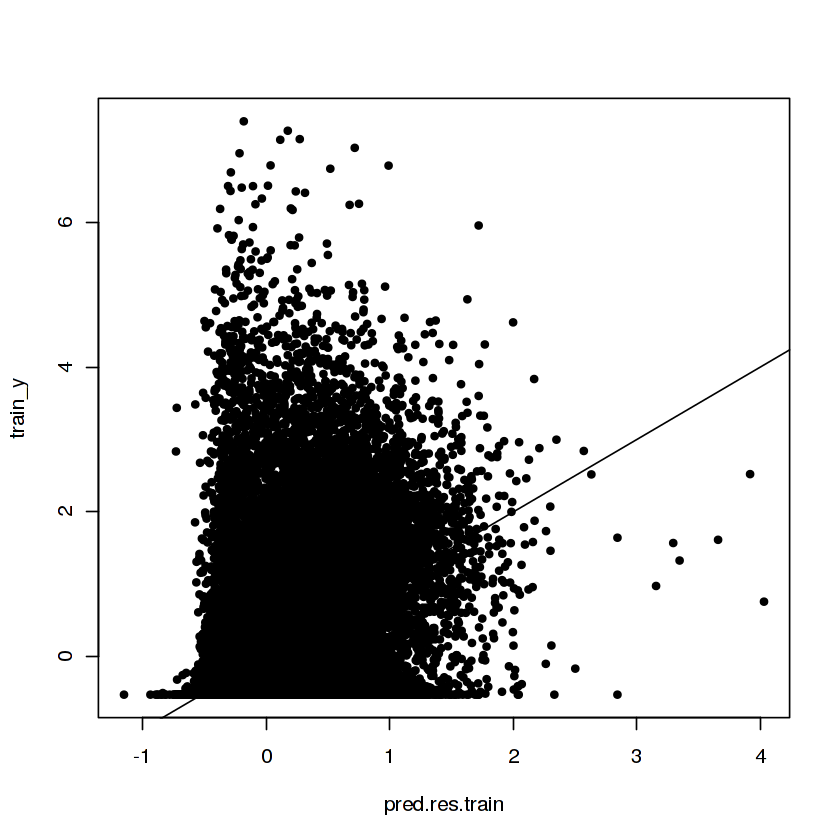

In [30]:
plot(pred.res.train, train_y, pch= 20)
abline(a=0, b= 1)

### Compute predictions on test data

In [37]:
pred.res.test <- predict(final_el, as.matrix(test_x),s= el.res[[best_alpha_idx]]$lambda.min, alpha= alphas[best_alpha_idx])
cor.df <- data.frame(cor_val= cor(pred.res.test, test_y), cor_method= "Pearson")
cor.df <- rbind(cor.df, data.frame(cor_val= cor(pred.res.test, test_y, method= "spearman"), cor_method= "Spearman"))
cor.df

,cor_val,cor_method
1,0.4560461,Pearson
11,0.5317603,Spearman


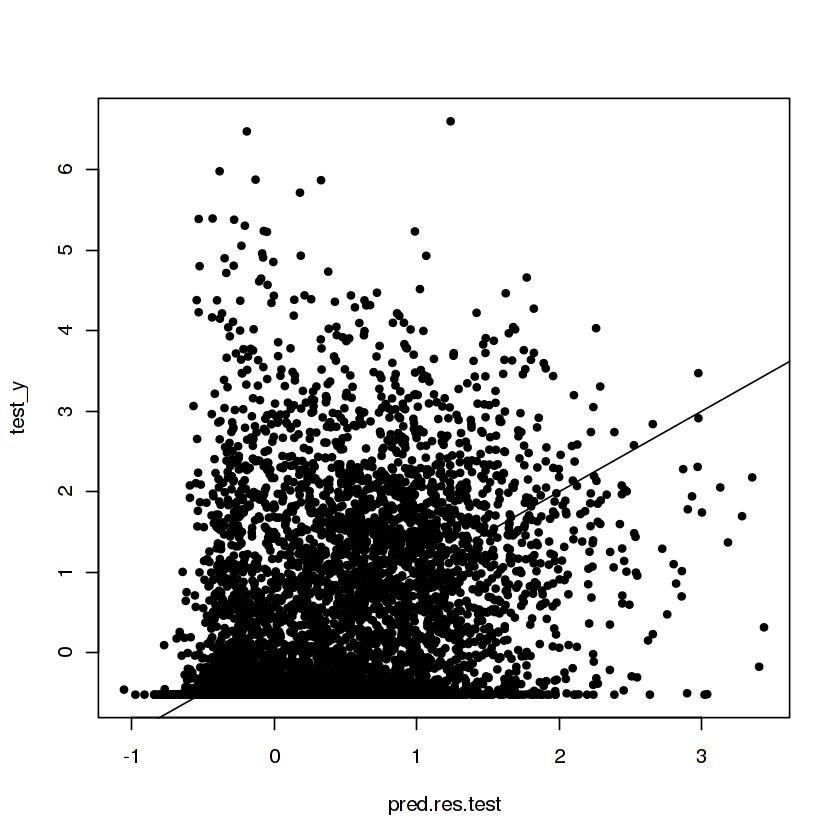

In [32]:
plot(pred.res.test, test_y, pch= 20)
abline(a=0, b= 1)

## Model coefficients representing the top TFs

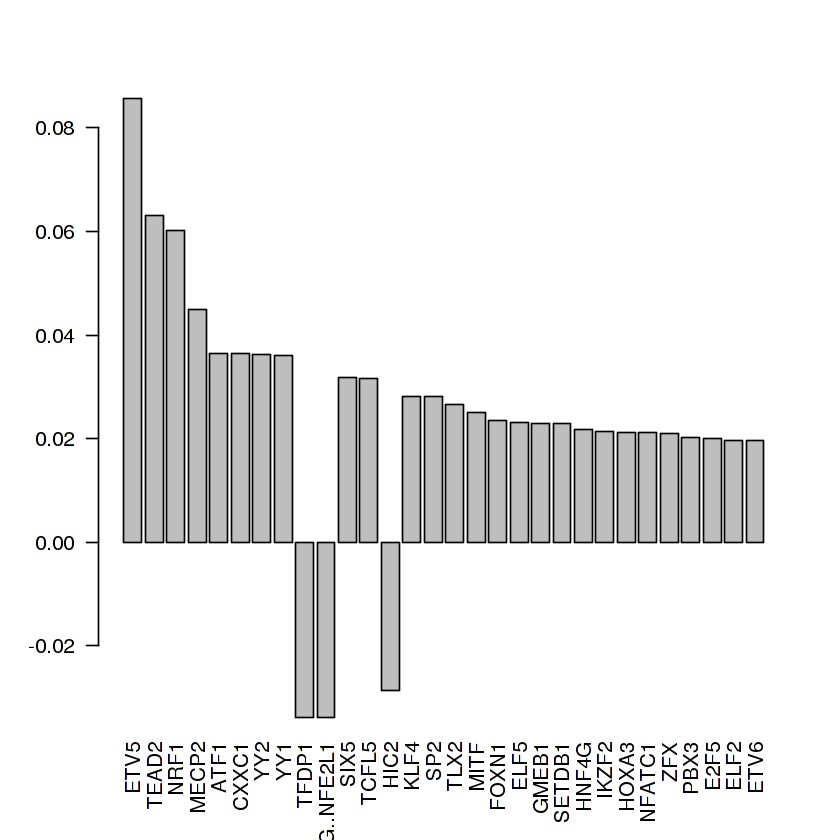

In [33]:
tf.names <- rownames(final_el$beta)
top.tfs <- order(abs(as.numeric(final_el$beta)), decreasing = T)[seq(30)]
barplot(as.numeric(final_el$beta)[top.tfs], las= 2, names.arg= tf.names[top.tfs])

## Examine the correlation between top TFs and response

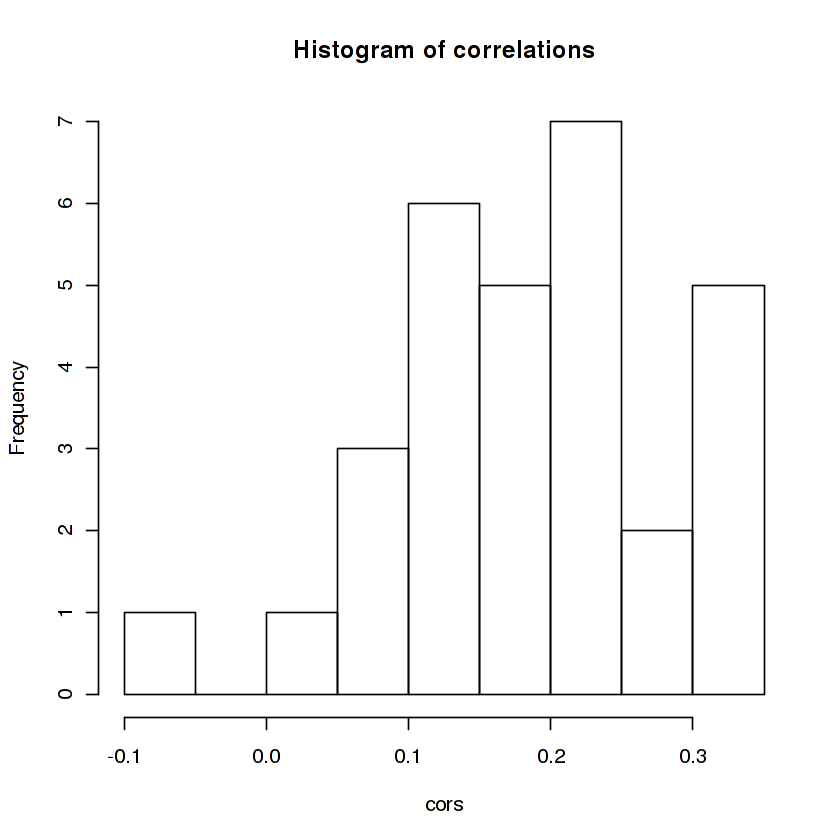

In [34]:
top_x <- train_x[, top.tfs]
cors <- sapply(seq(ncol(top_x)), function(i)cor(c(top_x[, i], test_x[, top.tfs[i]]), c(train_y, test_y)))
hist(cors, main= "Histogram of correlations")

# Conclusion
* The elastic net results show promising prediction performance for this particular setup.
* Not surprisingly, the top TFs exhibit the best correlations with response.